# Imports Libraries and Tools

In [1]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [3]:
import os
from sklearn.utils import shuffle

# Directories for training and testing data (Windows paths)
train_dir = r"C:\Users\moham\OneDrive\Desktop\brain-project\Training"
test_dir  = r"C:\Users\moham\OneDrive\Desktop\brain-project\Testing"

# Load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

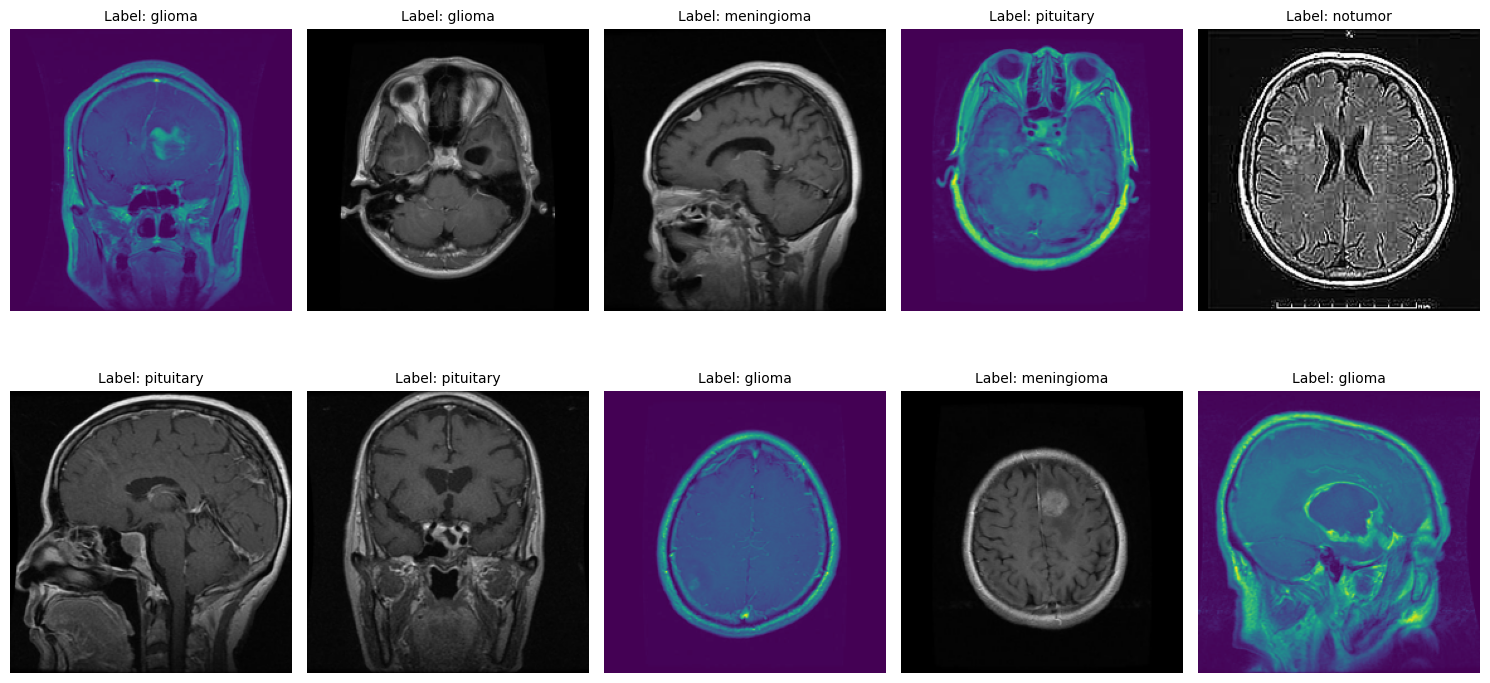

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing

In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:

## VGG16
The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers including 13 convolutional layers and 3 fully connected layers.

 This model is built on the VGG16, which is a pre-trained CNN for image classification.

* This model uses VGG16 as its base, which is a convolutional neural network that has already been trained for image classification tasks.

* First, the VGG16 network is loaded with an input size of 128 × 128 × 3 to match the image dimensions used in the dataset. The top classification layers are excluded by setting include_top=False, allowing the model to be customized for the current task. Pre-trained ImageNet weights are used, which come from training on a large dataset containing approximately 1.4 million images.

* Next, all layers of the VGG16 model are frozen by setting them as non-trainable. This ensures that the pre-learned feature extraction layers are preserved and not modified during training.

* After freezing the layers, the last three layers of the VGG16 network are selectively unfrozen. These layers are set as trainable so the model can fine-tune higher-level features based on the new dataset.

* Following this, a Sequential model is created and the VGG16 base model is added to it.

* The output from VGG16 is then flattened into a one-dimensional vector using a Flatten layer, making it suitable for input into the fully connected layers.

* To reduce overfitting, a Dropout layer with a rate of 0.3 is applied, which randomly disables a portion of neurons during training.

* A dense layer consisting of 128 neurons with a ReLU activation function is then added to the network, followed by another Dropout layer with a rate of 0.2 for additional regularization.

* Finally, the output layer is added with a number of neurons equal to the total number of unique classes in the dataset. A softmax activation function is used to generate probability values for each class.



In [6]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - loss: 0.4476 - sparse_categorical_accuracy: 0.8247
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - loss: 0.2256 - sparse_categorical_accuracy: 0.9153
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - loss: 0.1485 - sparse_categorical_accuracy: 0.9410
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - loss: 0.1163 - sparse_categorical_accuracy: 0.9585
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9666


# Train and Val Plots

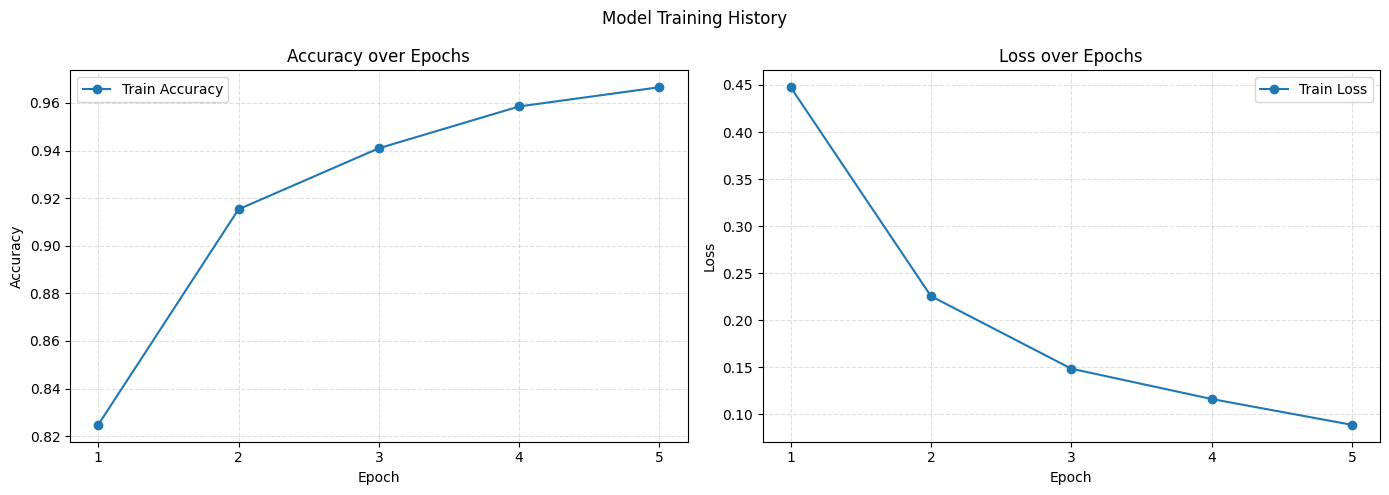

In [10]:
import numpy as np
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['sparse_categorical_accuracy'], 'o-', label='Train Accuracy')
if 'val_sparse_categorical_accuracy' in history.history:
    plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], 'o--', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'o-', label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(epochs, history.history['val_loss'], 'o--', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.suptitle('Model Training History')
plt.tight_layout()
plt.show()

# Model Classification 

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       300
           1       0.96      0.78      0.86       306
           2       1.00      0.98      0.99       405
           3       0.89      0.99      0.94       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



# Confusion Matrix

Confusion Matrix (Counts):
[[288   9   0   3]
 [ 32 240   1  33]
 [  8   0 395   2]
 [  0   2   0 298]]


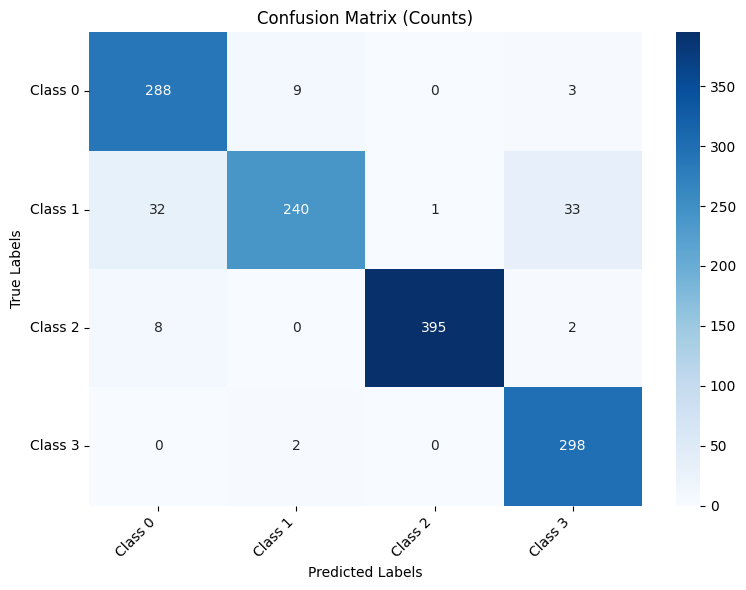

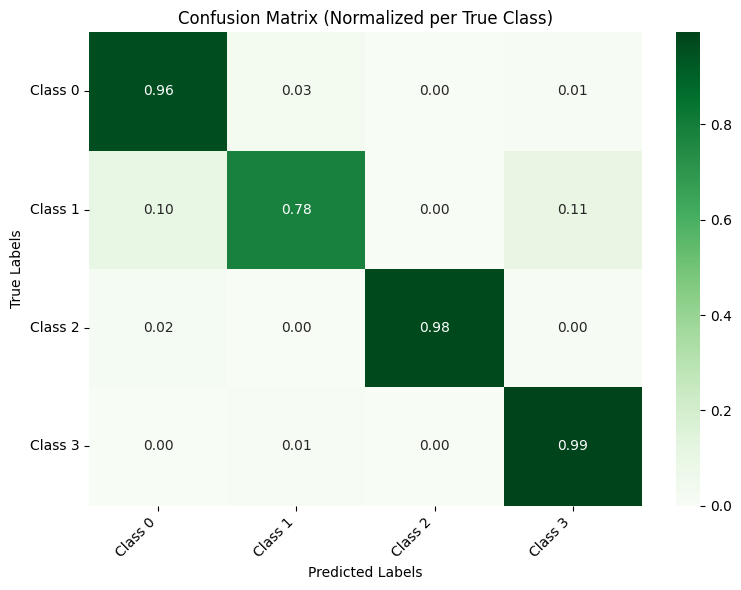

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true / y_pred for clarity
y_true = test_labels_encoded
y_pred = np.argmax(test_predictions, axis=1)

num_classes = len(np.unique(y_true))
if 'class_names' not in globals():
    class_names = [f'Class {i}' for i in range(num_classes)]

# 1) Confusion matrix (counts)
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(num_classes))
print("Confusion Matrix (Counts):")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Normalized confusion matrix (row-wise: per true class)
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  # handle division by zero

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix (Normalized per True Class)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ROC Curve Plot


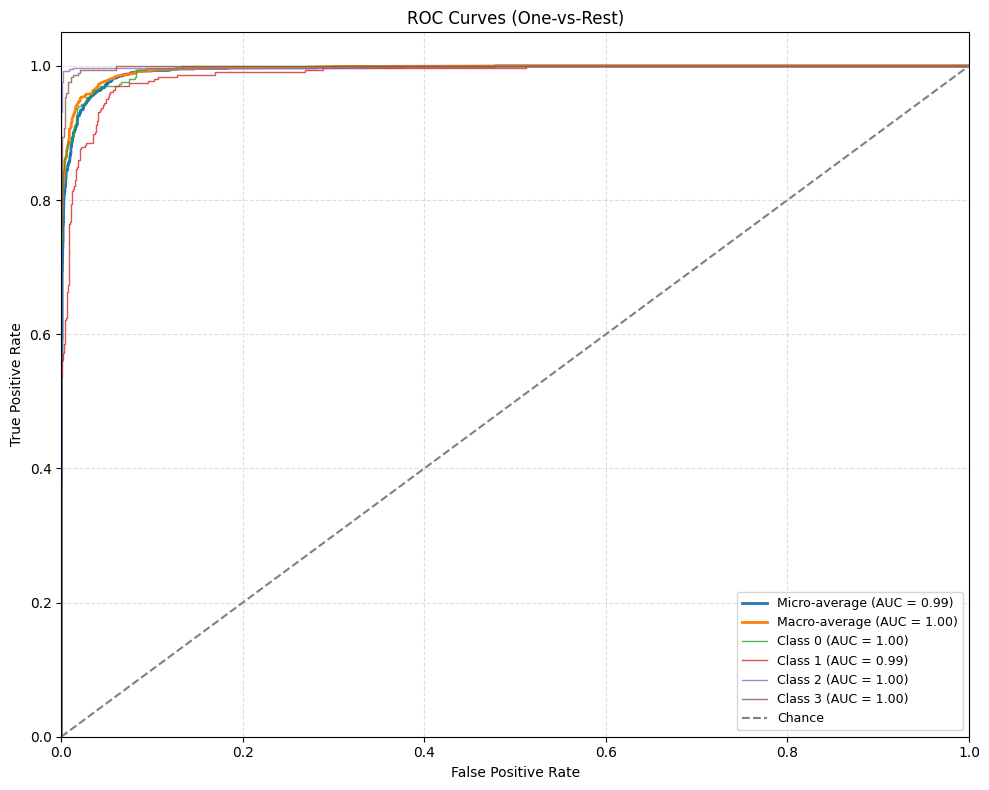

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Number of classes based on predictions
n_classes = test_predictions.shape[1]

# Binarize labels
classes = np.arange(n_classes)
y_true_bin = label_binarize(test_labels_encoded, classes=classes)
y_score = test_predictions  # predicted probabilities

# Per-class ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Optional: class names
# class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
if 'class_names' not in globals():
    class_names = [f'Class {i}' for i in range(n_classes)]

# Plot
plt.figure(figsize=(10, 8))

# Plot macro and micro first (thicker lines)
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
    linewidth=2
)
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
    linewidth=2
)

# Plot each class
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        linewidth=1,
        alpha=0.8,
        label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')

plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()


# Save & Load Model

In [44]:
# Save the entire model
model.save('model.h5')

In [45]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System

In [113]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['meningioma','glioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


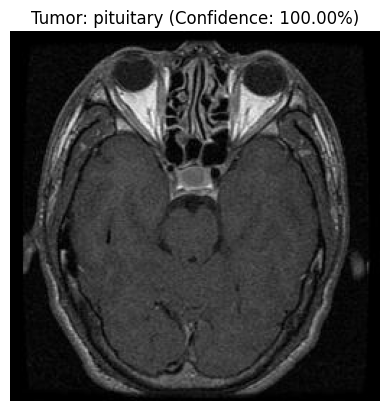

In [114]:
image_path = r"C:\Users\moham\OneDrive\Desktop\brain-project\Testing\pituitary\Te-pi_0063.jpg"
detect_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


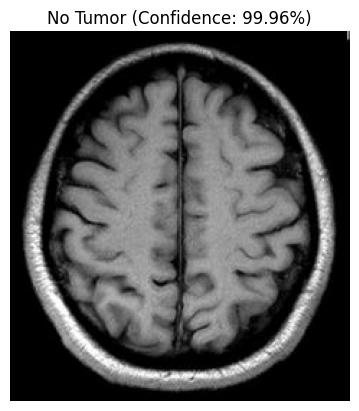

In [115]:
image_path = r'C:\Users\moham\OneDrive\Desktop\brain-project\Testing\notumor\Te-no_0065.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


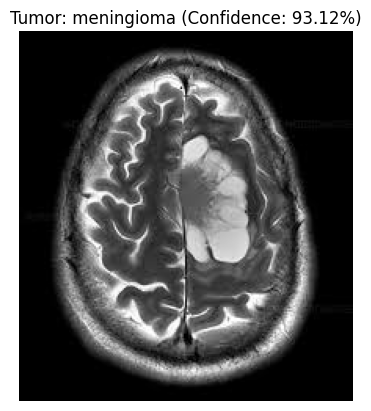

In [116]:
# Example usage
image_path = r'C:\Users\moham\OneDrive\Desktop\brain-project\Testing\meningioma\Te-me_0112.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)